# Importing packages and files

In [14]:
import json

import graphviz
import requests
from IPython.display import display
from anytree.exporter import DotExporter

URL = "127.0.0.1"
PORT = 8001

In [15]:
with open("bpmn_test_api.json", "r") as f:
    bpmn_file = f.read()

bpmn = json.loads(bpmn_file)

# Initialize petri net and execution tree

In [16]:
request_json = {
    "bpmn": bpmn
}

response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json=request_json)
response_json = response.json()

In [17]:
bpmn = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

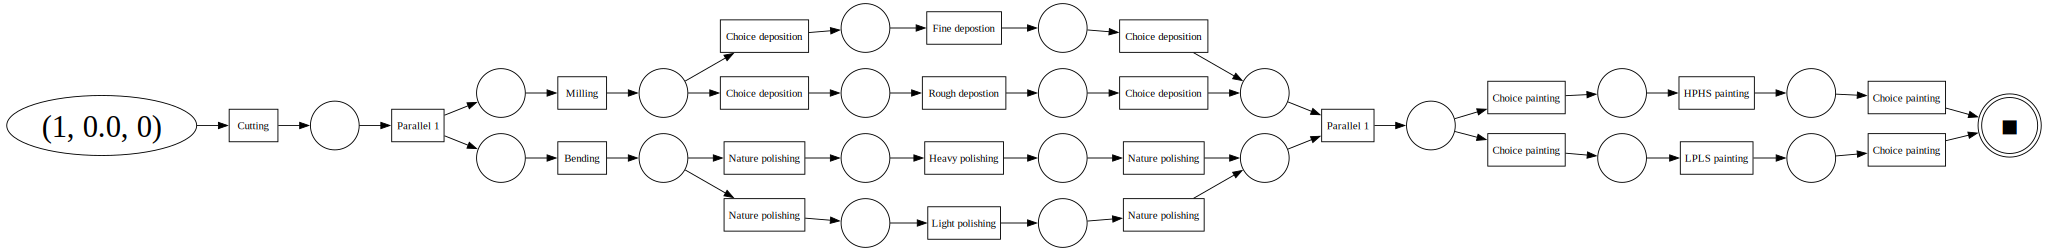

In [18]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

# Execute choice

In [19]:
request_json = {
    'bpmn': bpmn,
    'petri_net': petri_net,
    'petri_net_dot': petri_net_dot,
    'execution_tree': execution_tree,
     'choices': ['6'] # id delle transizioni con stop da eseguire, se non vengono passati vengono presi i default
}

response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json=request_json)
response_json = response.json()

In [20]:
bpmn = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

KeyError: 'bpmn'

In [ ]:
execution_tree

In [ ]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

In [ ]:
from model.endpoints.execute.request import ExecuteRequest

model = ExecuteRequest.model_validate_json(response.text)
extree = model.execution_tree_obj
extree_dot = "\n".join(DotExporter(extree.root))
display(graphviz.Source(extree_dot))

# Display BPMN

In [ ]:
from dot import get_active_region_by_pn, wrap_to_dot

impacts_names = ["a", "b"]
marking = {"21": {"token": 1}, "7": {"token": 1}}

active_region_by_pn = get_active_region_by_pn(petri_net, marking)
dot = wrap_to_dot(bpmn, impacts_names, active_region_by_pn)
graph = graphviz.Source(dot, format="svg")

display(graph)

# Display Execution Tree

In [ ]:
ACTIVE_NODE_COLOR = "ffa500"  # Orange
INACTIVE_NODE_COLOR = "808080"  # Grey
TEXT_COLOR = "000000"  # Black
ALPHA_ACTIVE_BACKGROUND = "ff"  # Full opacity for visible nodes
ALPHA_ACTIVE_TEXT = "ff"  # Full opacity for visible nodes
ALPHA_INACTIVE_BACKGROUND = "7f"  # Semi-transparent for inactive nodes
ALPHA_INACTIVE_TEXT = "7f"  # Semi-transparent for inactive nodes


def node_to_dot(_id, p, impacts, execution_time, impacts_name=None, visible=True):
    if impacts_name is None or len(impacts_name) == 0:
        impacts_name = [i + 1 for i in range(len(impacts))]

    bg_color = ACTIVE_NODE_COLOR if visible else INACTIVE_NODE_COLOR  # Use active color if visible, inactive if not
    alpha_bg = ALPHA_ACTIVE_BACKGROUND if visible else ALPHA_INACTIVE_BACKGROUND  # Full opacity if visible, semi-transparent if not
    alpha_text = ALPHA_ACTIVE_TEXT if visible else ALPHA_INACTIVE_TEXT  # Full opacity if visible, semi-transparent if not
    impacts_label = f"[{", ".join([f"{name}: {value}" for name, value in zip(impacts_name, impacts)])}]"
    return f'\nnode_{_id}[shape=oval label="ID: {_id}\\nProbability: {p}\\nImpacts:\\n{impacts_label}\\nExecution time: {execution_time}" style="filled" fillcolor="#{bg_color}{alpha_bg}" fontcolor="#{TEXT_COLOR}{alpha_text}"];'


def tree_to_dot(tree_root, impacts_names, path=None):
    """
    Render the execution tree as a dot representation.
    :param tree_root: Root of the execution tree
    :param impacts_names: Impacts names to display
    :param path: Ids of the nodes in the path to highlight
    :return: Dot representation of the execution tree
    """
    if path is None:
        path = []

    def apply(root):
        code = ""
        is_active = root.get('id') in path

        node_id = root.get('id')
        snapshot = root.get('snapshot', {})
        p = snapshot.get('p', 1.0)
        impacts = snapshot.get('impacts', [0 for _ in impacts_names])
        execution_time = snapshot.get('execution_time', 0)

        code += node_to_dot(
            node_id,
            p,
            impacts,
            execution_time,
            impacts_name=impacts_names,
            visible=is_active
        )

        for child in root.get("children", []):
            child_code = apply(child)
            code += child_code
            code += f'\nnode_{root.get("id")} -> node_{child.get("id")};\n'

        return code

    return apply(tree_root)


def wrapper_execution_tree_to_dot(tree_root, impacts_names, path=None):
    """
    Wrapper to create the dot representation of the execution tree.
    :param tree_root: Execution tree object
    :param impacts_names: Impacts names to display
    :param path: Ids of the nodes in the path to highlight
    :return: Dot representation of the execution tree
    """
    code = "digraph G {\n"
    code += tree_to_dot(tree_root, impacts_names, path)
    code += "\n}"

    return code


def get_path_to_current_node(tree_root, current_node_id):
    """
    Get the path to the current node in the execution tree.
    :param tree_root: Root of the execution tree
    :param current_node_id: ID of the current node
    :return: List of node IDs in the path to the current node
    """
    if tree_root.get('id') == current_node_id:
        return [current_node_id]

    for child in tree_root.get("children", []):
        path = get_path_to_current_node(child, current_node_id)
        if path is not None:
            return [tree_root.get('id')] + path

    return None


current_path = get_path_to_current_node(execution_tree.get("root", {}), execution_tree.get("current_node"))
dot = wrapper_execution_tree_to_dot(execution_tree.get("root", {}), impacts_names, current_path)
graph = graphviz.Source(dot, format="svg")
display(graph)

In [ ]:
execution_tree